# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.5.1+cu121', torchvision.__version__='0.20.1+cu121', device=device(type='cpu'), torch.get_num_threads()=1


### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

Read data from .zip file

In [ ]:
from google.colab import files
import zipfile
import pandas as pd

zip_file_path = "Train_rev1.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

csv_file_path = "Train_rev1.csv"
data = pd.read_csv(csv_file_path, index_col=None)

print(data.head())

FileNotFoundError: [Errno 2] No such file or directory: 'Train_rev1.zip'

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
76596,69007823,Lecturer in Electronics,Lecturer in Electronics and Electrical Enginee...,Somerset,Somerset,NaN,permanent,Boston Rose,Engineering Jobs,22000 - 25359/annum 25 days hol,23679,cv-library.co.uk,10.072386
12287,66546059,"Direct Sales Advisor Southampton covering SO,...",Working directly for Sky in our Direct Sales t...,Southampton,Southampton,full_time,NaN,British Sky Broadcasting Ltd,Sales Jobs,Salary: OTE 34k Unlimited + Healthcare,34000,Jobcentre Plus,10.434145
147309,70757696,Commercial Insurance Team Leader,We are currently recruiting for a Commercial I...,West Sussex,West Sussex,NaN,permanent,First Recruitment Services,Accounting & Finance Jobs,28000 - 33000/annum,30500,cv-library.co.uk,10.325515


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [ ]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row in data.iloc():
    token_counts.update(row['Title'].split(' '))
    token_counts.update(row['FullDescription'].split(' '))

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

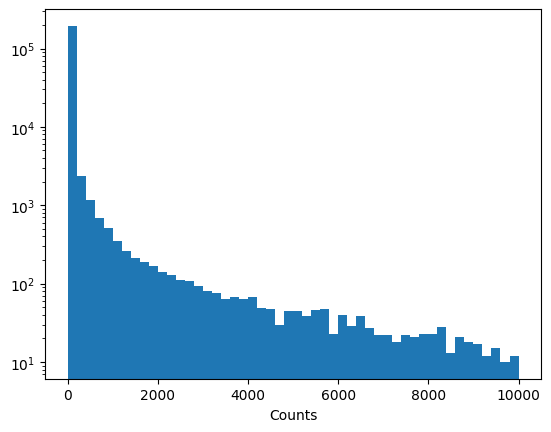

In [ ]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(map(lambda item: item[0], filter(lambda item: item[1] >= min_count, token_counts.items())))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [ ]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)

    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)

    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch

In [ ]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 872,  648,    1,    1,    1,    1,    1,    1,    1],
        [1515, 1797, 7835,  130, 3489,  981, 2380, 1407, 2182],
        [   0, 7398, 2805,    1,    1,    1,    1,    1,    1]],
       dtype=int32),
 'FullDescription': array([[ 872,  648,    7,  129,    8,    9,    8,    9,   44,  449],
        [2686, 7835,  130, 3489,  981, 2380,  130, 1515, 1797,  377],
        [   0, 2805,   12,  169,  863,  183, 4033,  509,  557,   11]],
       dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.998843, 10.146473, 10.389026], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim

    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


In [ ]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)

        return h

In [ ]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [ ]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(300, 150, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm1d(150)
        self.conv2 = nn.Conv1d(150, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)

        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.batch1(h)
        h = self.conv2(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)

        return h

In [ ]:
desc_encoder = DescriptionsEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [ ]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """

    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = TitleEncoder(out_size=64).to(device)
        self.desc_encoder = DescriptionsEncoder(out_size=64).to(device)

        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 64)
        self.batch1 = nn.BatchNorm1d(64)

        # define "output" layers that process depend the three encoded vectors into answer
        self.dense3 = nn.Linear(192, 32)
        self.batch2 = nn.BatchNorm1d(32)
        self.dense4 = nn.Linear(32, 16)
        self.dense5 = nn.Linear(16, 1)


    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """

        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        title_h = F.dropout(title_h, p=0.1)
        desc_h = self.desc_encoder(desc_ix)
        desc_h = F.dropout(desc_h, p=0.1)

        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = F.relu(cat_h)
        cat_h = self.dense2(cat_h)
        cat_h = self.batch1(cat_h)

        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        # ... and stack a few more layers at the top
        h = self.dense3(joint_h)
        h = self.batch2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.1)
        h = self.dense4(h)
        h = self.dense5(h)

        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.

        return h[:, 0]

In [ ]:
model = FullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features).to(device)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [ ]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [ ]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [ ]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]

    irange = tnrange if verbose else range

    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [ ]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [ ]:
for epoch_i in range(num_epochs):

    print("Training:")
    train_loss = train_mae = train_batches = 0
    model.train(True)

    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1

    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')

    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	52.21907
	MAE:	12218.69557



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.82567
	MAE:	10460.89211



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	3.21163
	MAE:	30708.29803



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.11227
	MAE:	10999.47924



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.26006
	MAE:	24472.56981



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.49694
	MAE:	17017.57622



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	2.14496
	MAE:	28092.21545



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.15395
	MAE:	12071.36095



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.81032
	MAE:	19405.90979



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.38780
	MAE:	9235.13912



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.69634
	MAE:	17348.12094



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.91377
	MAE:	31215.38678



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.61979
	MAE:	18162.51342



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.68428
	MAE:	8760.11094



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.40064
	MAE:	14667.66885



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.35520
	MAE:	19234.91161



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.43492
	MAE:	15191.20543



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.77306
	MAE:	8530.39444



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.41765
	MAE:	15178.12112



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.27787
	MAE:	19594.75759



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.18828
	MAE:	12418.23697



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.04088
	MAE:	8869.51499



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.18890
	MAE:	12777.61744



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.09296
	MAE:	10899.95813



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.18395
	MAE:	12759.60108



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.91043
	MAE:	9773.38165



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.12950
	MAE:	12349.61509



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.92494
	MAE:	11180.82402



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.00715
	MAE:	11198.91608



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.86126
	MAE:	9024.92072



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.04475
	MAE:	11577.59201



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.86523
	MAE:	12308.87640



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.97850
	MAE:	11065.31894



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.87244
	MAE:	13259.97646



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.90923
	MAE:	10465.70703



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.71558
	MAE:	8131.02127



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.92023
	MAE:	10544.10204



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.85308
	MAE:	7226.60741



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.93256
	MAE:	10442.91686



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.81361
	MAE:	7697.23141



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.82623
	MAE:	9717.27195



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.71455
	MAE:	7088.08759



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.83136
	MAE:	9493.58637



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.75795
	MAE:	11059.73157



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.82118
	MAE:	9762.56264



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.67307
	MAE:	8696.86255



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.74847
	MAE:	9089.08668



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.76200
	MAE:	6591.40520



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.70152
	MAE:	8677.89329



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.60977
	MAE:	6947.19443



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.67405
	MAE:	8508.29315



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.59062
	MAE:	7736.41799



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.66167
	MAE:	8544.37470



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.58308
	MAE:	7751.82453



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.67283
	MAE:	8423.11040



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.60118
	MAE:	9207.43071



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.68867
	MAE:	8731.27061



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.57807
	MAE:	7551.09531



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.64647
	MAE:	8244.37255



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.51486
	MAE:	6708.79939



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.61035
	MAE:	7939.39463



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.49823
	MAE:	6563.00552



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.60425
	MAE:	8022.10101



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.48862
	MAE:	5888.75032



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.53257
	MAE:	7592.74760



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.45263
	MAE:	6154.61719



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.53867
	MAE:	7613.40076



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43753
	MAE:	6615.36539



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.50202
	MAE:	7156.22172



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43313
	MAE:	5853.89120



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.49032
	MAE:	6988.93908



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.42329
	MAE:	6720.63892



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.46459
	MAE:	6911.19437



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.39900
	MAE:	5901.52811



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.44443
	MAE:	6765.21243



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.39735
	MAE:	5802.58596



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.42355
	MAE:	6397.17806



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.36927
	MAE:	5596.07662



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.42946
	MAE:	6453.93321



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35026
	MAE:	5612.59042



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.41676
	MAE:	6468.28676



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.38797
	MAE:	5264.95516



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.37546
	MAE:	5925.08827



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.31923
	MAE:	5334.49746



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.38334
	MAE:	6184.95508



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32714
	MAE:	6171.05129



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.34320
	MAE:	5786.83146



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29122
	MAE:	5064.17529



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33711
	MAE:	5844.92399



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28180
	MAE:	5086.47476



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.31862
	MAE:	5489.68324



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26286
	MAE:	4936.08060



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.30355
	MAE:	5355.79987



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25120
	MAE:	5168.93169



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29257
	MAE:	5344.04569



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24171
	MAE:	4600.60635



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26701
	MAE:	5059.52102



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22780
	MAE:	4890.45129



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26313
	MAE:	4965.86079



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21413
	MAE:	4281.44650



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23733
	MAE:	4676.70355



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21332
	MAE:	4773.43707



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22476
	MAE:	4604.41958



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20469
	MAE:	4069.73088



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22226
	MAE:	4544.99656



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18044
	MAE:	4123.61525



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19193
	MAE:	4180.82495



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17568
	MAE:	4193.80501



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20170
	MAE:	4324.13823



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17281
	MAE:	3995.96784



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18736
	MAE:	4324.48545



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16173
	MAE:	4022.75207



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16704
	MAE:	4055.15070



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14983
	MAE:	3641.61015



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15418
	MAE:	3944.54857



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15153
	MAE:	3603.93959



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15969
	MAE:	3992.41904



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13799
	MAE:	3501.99038



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14612
	MAE:	3725.97281



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12868
	MAE:	3421.22906



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14091
	MAE:	3733.36391



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16377
	MAE:	3733.28839



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12349
	MAE:	3500.19951



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11921
	MAE:	3290.05221



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12682
	MAE:	3497.56635



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11294
	MAE:	3304.75416



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13197
	MAE:	3522.36348



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11831
	MAE:	3441.46403



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11832
	MAE:	3441.90851



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10758
	MAE:	3137.23503



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10983
	MAE:	3212.33940



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10756
	MAE:	3133.00476



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11408
	MAE:	3305.61713



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10842
	MAE:	3135.57394



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10657
	MAE:	3242.31175



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09569
	MAE:	2975.40575



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10678
	MAE:	3245.85212



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09472
	MAE:	2991.78366



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10694
	MAE:	3177.29565



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12364
	MAE:	3717.59213



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11173
	MAE:	3244.40267



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17432
	MAE:	4017.37175



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10445
	MAE:	3126.78692



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08818
	MAE:	2845.85894



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09211
	MAE:	2974.22472



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09435
	MAE:	3056.47214



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09442
	MAE:	2998.90825



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08721
	MAE:	2879.87248



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09242
	MAE:	2946.12214



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08702
	MAE:	2874.19119



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09115
	MAE:	3020.82906



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08408
	MAE:	2778.03395



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08665
	MAE:	2891.76068



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08141
	MAE:	2750.53409



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09283
	MAE:	2887.32667



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08345
	MAE:	2828.12477



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09274
	MAE:	2930.48424



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08271
	MAE:	2809.59313



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09260
	MAE:	3001.51095



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08533
	MAE:	2799.53967



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09633
	MAE:	3050.56568



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09509
	MAE:	2966.75653



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08578
	MAE:	2887.98400



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08858
	MAE:	2857.42094



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08762
	MAE:	2867.45167



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08108
	MAE:	2723.60048



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08526
	MAE:	2866.43561



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07855
	MAE:	2689.43110



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09071
	MAE:	2905.30757



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08929
	MAE:	2867.00739



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08045
	MAE:	2792.49620



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10405
	MAE:	3456.70069



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09253
	MAE:	3035.02933



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09011
	MAE:	3050.46569



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09059
	MAE:	2943.17084



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07728
	MAE:	2644.64864



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08377
	MAE:	2806.84265



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08013
	MAE:	2710.32684



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08679
	MAE:	2860.59078



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07960
	MAE:	2703.96558



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08740
	MAE:	2913.82215



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08487
	MAE:	2797.55561



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08786
	MAE:	2857.06866



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08425
	MAE:	2769.32549



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08483
	MAE:	2934.29870



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11717
	MAE:	3915.04452



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09757
	MAE:	3081.60277



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09100
	MAE:	3114.85075



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08913
	MAE:	2853.40734



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07597
	MAE:	2625.29564



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07382
	MAE:	2657.96038



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07500
	MAE:	2673.40701



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07900
	MAE:	2772.76665



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07611
	MAE:	2627.90616



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07762
	MAE:	2813.45848



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07544
	MAE:	2610.99244



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07815
	MAE:	2640.77723



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07624
	MAE:	2638.43685



Training:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08793
	MAE:	2816.70411



Validation:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08532
	MAE:	2813.44280





In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


<ipython-input-36-a234f2910e43>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for start in irange(0, len(indices), batch_size):


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08574
	MAE:	2822.19157



